In [3]:
!pip install kaggle

In [4]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"jonasdixon99","key":"4937237224bfad50b5fe865d0bd57caf"}'}

In [5]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Downloading and extracting the dataset
!kaggle competitions download -c cancer-classification-challenge-2024
!unzip cancer-classification-challenge-2024.zip -d ./cancer_classification


Streaming output truncated to the last 5000 lines.
  inflating: ./cancer_classification/train/pat_086_ind_7706.jpg  
  inflating: ./cancer_classification/train/pat_086_ind_7707.jpg  
  inflating: ./cancer_classification/train/pat_086_ind_7708.jpg  
  inflating: ./cancer_classification/train/pat_086_ind_7709.jpg  
  inflating: ./cancer_classification/train/pat_086_ind_771.jpg  
  inflating: ./cancer_classification/train/pat_086_ind_7710.jpg  
  inflating: ./cancer_classification/train/pat_086_ind_7711.jpg  
  inflating: ./cancer_classification/train/pat_086_ind_7712.jpg  
  inflating: ./cancer_classification/train/pat_086_ind_7713.jpg  
  inflating: ./cancer_classification/train/pat_086_ind_7714.jpg  
  inflating: ./cancer_classification/train/pat_086_ind_7715.jpg  
  inflating: ./cancer_classification/train/pat_086_ind_7716.jpg  
  inflating: ./cancer_classification/train/pat_086_ind_7717.jpg  
  inflating: ./cancer_classification/train/pat_086_ind_7718.jpg  
  inflating: ./cancer_clas

In [8]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.model_selection import train_test_split
from PIL import Image
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.nn.init as init
from sklearn.metrics import roc_auc_score

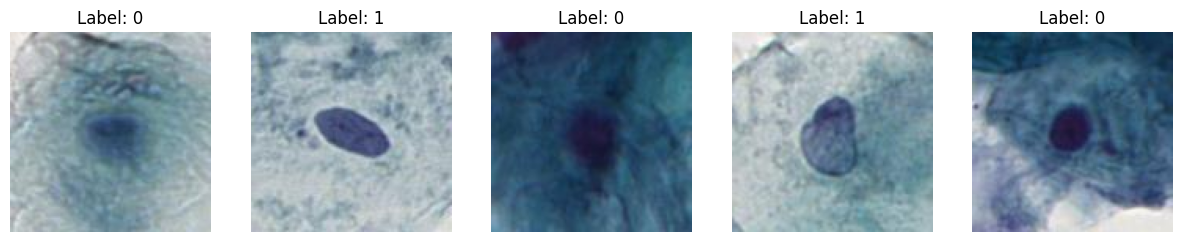

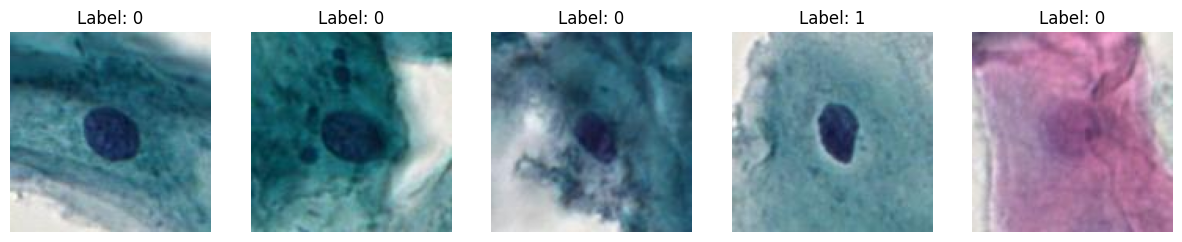

In [9]:
# Define paths
data_dir = './cancer_classification'
csv_path = os.path.join(data_dir, 'train.csv')
image_folder = os.path.join(data_dir, 'train')

# Load the CSV file with labels
data_df = pd.read_csv(csv_path)

# Dateset class
class CancerDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.annotations.iloc[idx, 0])
        image = Image.open(img_path).convert("RGB")
        label = torch.tensor(int(self.annotations.iloc[idx, 1]))

        if self.transform:
            image = self.transform(image)

        return image, label

transform = transforms.Compose([
    transforms.ToTensor(),
])

# Loading the dataset
train_dataset = CancerDataset(csv_file=csv_path, img_dir=image_folder, transform=transform)

# Splitting into training and validation sets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Creating DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers = 2)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True, num_workers = 2)

# Visualizing some training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i, (img, lbl) in enumerate(zip(images[:5], labels[:5])):
    axes[i].imshow(transforms.ToPILImage()(img))
    axes[i].set_title(f"Label: {lbl.item()}")
    axes[i].axis('off')
plt.show()

# Visualize some validation images
dataiter = iter(val_loader)
images, labels = next(dataiter)

fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i, (img, lbl) in enumerate(zip(images[:5], labels[:5])):
    axes[i].imshow(transforms.ToPILImage()(img))
    axes[i].set_title(f"Label: {lbl.item()}")
    axes[i].axis('off')
plt.show()


In [10]:
# Setting GPU as device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv1_bn = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv2_bn = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3_bn = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv4_bn = nn.BatchNorm2d(128)
        self.conv5 = nn.Conv2d(128, 256, 3, padding=1)
        self.conv5_bn = nn.BatchNorm2d(256)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(256 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 1)
        self.dropout = nn.Dropout(0.25)

        # Kaiming He initialization
        nn.init.kaiming_normal_(self.conv1.weight, mode='fan_out', nonlinearity='relu')
        nn.init.kaiming_normal_(self.conv2.weight, mode='fan_out', nonlinearity='relu')
        nn.init.kaiming_normal_(self.conv3.weight, mode='fan_out', nonlinearity='relu')
        nn.init.kaiming_normal_(self.conv4.weight, mode='fan_out', nonlinearity='relu')
        nn.init.kaiming_normal_(self.conv5.weight, mode='fan_out', nonlinearity='relu')
        nn.init.kaiming_normal_(self.fc1.weight, mode='fan_out', nonlinearity='relu')
        nn.init.kaiming_normal_(self.fc2.weight, mode='fan_out', nonlinearity='relu')

    def forward(self, x):
        x = self.pool(F.relu(self.conv1_bn(self.conv1(x))))
        x = self.pool(F.relu(self.conv2_bn(self.conv2(x))))
        x = self.pool(F.relu(self.conv3_bn(self.conv3(x))))
        x = self.pool(F.relu(self.conv4_bn(self.conv4(x))))
        x = self.pool(F.relu(self.conv5_bn(self.conv5(x))))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x.squeeze()


Epoch [1/2], Train Loss: 139.0397, Train AUC: 0.7090, Val Loss: 35.6847, Val AUC: 0.7640
0.001
Epoch [2/2], Train Loss: 33.9253, Train AUC: 0.7782, Val Loss: 36.4412, Val AUC: 0.7637
0.001


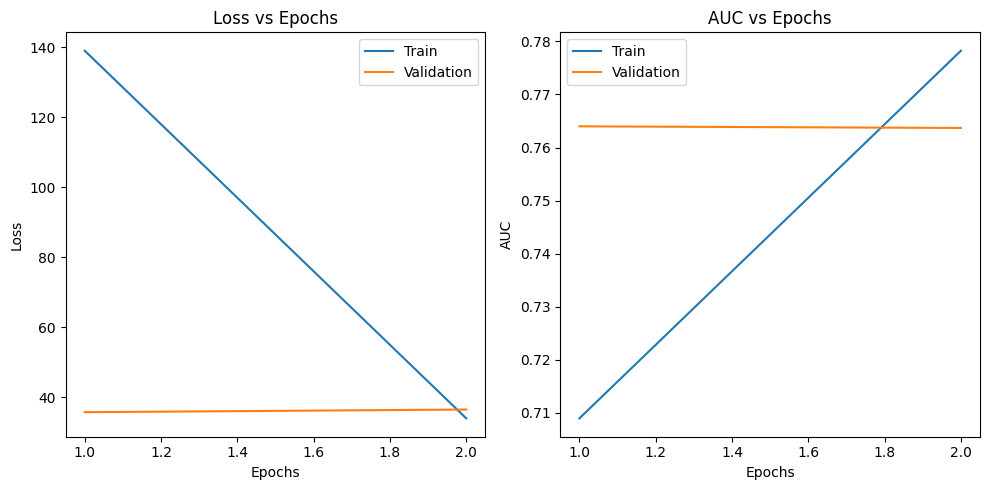

In [14]:
import torch.optim.lr_scheduler as lr_scheduler
from IPython.display import clear_output

# Defining the number of epochs
epochs = 26

# Instantiating the model, loss function, optimizer and learning rate schedule
model = ConvNet().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.2)

# Accuracy function
def compute_accuracy(predictions, labels):
    predicted_classes = (torch.sigmoid(predictions) > 0.5).float()
    correct = (predicted_classes == labels).float()
    accuracy = correct.sum() / len(correct)
    return accuracy

# AUC function
def compute_auc(predictions, labels):
    predicted_probabilities = torch.sigmoid(predictions).detach().cpu().numpy()
    true_labels = labels.detach().cpu().numpy()
    auc = roc_auc_score(true_labels, predicted_probabilities)

    return auc

# Model evaluation function
def evaluate_model(model, dataloader):
    model.eval()
    total_loss = 0.0
    total_accuracy = 0.0
    total_samples = 0

    i=0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels.float())
            total_loss += loss.item() * len(labels)
            total_accuracy += compute_auc(outputs, labels)
            total_samples += len(labels)
            i+=1

    avg_loss = total_loss / i
    avg_accuracy = total_accuracy / i
    return avg_loss, avg_accuracy

# Initialize lists
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Loop for training the model
epoch_iter = 0
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    running_accuracy = 0.0
    j = 0

    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * len(labels)
        running_accuracy += compute_auc(outputs, labels).item()

        j+=1

    avg_train_loss = running_loss / j
    avg_train_accuracy = running_accuracy / j

    # Evaluate on the validation set after each epoch
    val_loss, val_accuracy = evaluate_model(model, val_loader)

    print(f"Epoch [{epoch+1}/{epochs}], "
          f"Train Loss: {avg_train_loss:.4f}, Train AUC: {avg_train_accuracy:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val AUC: {val_accuracy:.4f}")

    # Update the learning rate from the scheduler
    scheduler.step()
    print(optimizer.param_groups[0]['lr'])

    # Collect AUC and loss
    train_losses.append(avg_train_loss)
    train_accuracies.append(avg_train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy.item())

    epoch_iter+=1

# Plotting the training graphs
plt.figure(figsize=(10, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, label='Train')
plt.plot(range(1, epochs + 1), val_losses, label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend()

# AUC
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_accuracies, label='Train')
plt.plot(range(1, epochs + 1), val_accuracies, label='Validation')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.title('AUC vs Epochs')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
test_folder = './cancer_classification/test'

class TestDataset(Dataset):
    def __init__(self, folder, transform=None):
        self.img_paths = [os.path.join(folder, img_name) for img_name in os.listdir(folder)]
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, os.path.basename(img_path)

test_transform = transforms.Compose([
    transforms.ToTensor(),
])

# Loading the test data
test_dataset = TestDataset(folder=test_folder, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Predict on test-set function
def predict(model, data_loader):
    model.eval()
    predictions = []

    with torch.no_grad():
        for images, filenames in data_loader:
            images = images.to(device)
            outputs = torch.sigmoid(model(images))

            for output, filename in zip(outputs, filenames):
                predictions.append((filename, output.item()))

    return predictions

# Predict on test-set
test_predictions = predict(model, test_loader)
predictions_df = pd.DataFrame(test_predictions, columns=['Name', 'Diagnosis'])

# Creating the CSV file of the predictions
predictions_df.to_csv('test_predictions.csv', index=False)

print("Predictions saved to 'test_predictions.csv'")
